# 台灣各縣市高齡人口與長照資源供需分析

本筆記本依據研究方法，分析民國 113 年台灣各縣市高齡人口結構與長照資源配置情況。

**研究方法架構：**
1. 描述性統計
2. 服務密度分析
3. 供需落差分析
4. 交叉比對分析
5. 視覺化統計


In [1]:
# 導入所需套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from math import pi
import warnings
import os

warnings.filterwarnings('ignore')

# 設定中文字型
print("正在設定中文字型...")
noto_font_dir = './fonts/Noto_Sans_TC/static'
if os.path.exists(noto_font_dir):
    font_files = {
        'Regular': os.path.join(noto_font_dir, 'NotoSansTC-Regular.ttf'),
        'Bold': os.path.join(noto_font_dir, 'NotoSansTC-Bold.ttf'),
        'Medium': os.path.join(noto_font_dir, 'NotoSansTC-Medium.ttf')
    }
    for weight, font_path in font_files.items():
        if os.path.exists(font_path):
            font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.sans-serif'] = ['Noto Sans TC']
    plt.rcParams['axes.unicode_minus'] = False
    print("✓ 字型設定完成")

sns.set_theme(style='whitegrid', font='Noto Sans TC')
plt.rcParams['figure.figsize'] = (12, 6)


正在設定中文字型...
✓ 字型設定完成


## 資料載入與清理


In [2]:
# 載入人口資料
df_pop = pd.read_csv('程式用-縣市人口按性別及五齡組.csv', encoding='utf-8')
df_pop.columns = df_pop.columns.str.strip()

# 清理數值欄位
numeric_cols = ['總人口', '65～69', '70～74', '75～79', '80～84', '85～89', '90～94', '95～99', '100以上', '65以下']
for col in numeric_cols:
    if col in df_pop.columns:
        df_pop[col] = df_pop[col].astype(str).str.replace(',', '').str.replace(' ', '').astype(float)

df_pop['區域別'] = df_pop['區域別'].str.strip()

# 計算 65 歲以上人口
age_cols = ['65～69', '70～74', '75～79', '80～84', '85～89', '90～94', '95～99', '100以上']
df_pop['65歲以上'] = df_pop[age_cols].sum(axis=1)
df_pop['老年人口比例(%)'] = (df_pop['65歲以上'] / df_pop['總人口']) * 100

print(f"人口資料: {len(df_pop)} 筆, {df_pop['區域別'].nunique()} 個縣市, 年份 {df_pop['年份'].min()}-{df_pop['年份'].max()}")


人口資料: 220 筆, 22 個縣市, 年份 104-113


In [3]:
# 載入長照 ABC 據點資料
df_ltc = pd.read_csv('data/長照ABC據點.csv', encoding='utf-8')

# 建立縣市代碼對照表
city_code_mapping = {
    '63000': '台北市', '64000': '高雄市', '65000': '新北市', '66000': '台中市',
    '67000': '台南市', '68000': '桃園市', '10002': '宜蘭縣', '10004': '新竹縣',
    '10005': '苗栗縣', '10007': '彰化縣', '10008': '南投縣', '10009': '雲林縣',
    '10010': '嘉義縣', '10013': '屏東縣', '10014': '台東縣', '10015': '花蓮縣',
    '10016': '澎湖縣', '10017': '基隆市', '10018': '新竹市', '10020': '嘉義市',
    '09007': '連江縣', '09020': '金門縣'
}

df_ltc['縣市代碼'] = df_ltc['縣市'].astype(str).str.strip().str.replace('"', '')
df_ltc['縣市名稱'] = df_ltc['縣市代碼'].map(city_code_mapping)
df_ltc['據點類型'] = df_ltc['O_ABC'].astype(str).str.strip().str.replace('"', '')

# 過濾有效資料
df_ltc_valid = df_ltc[(df_ltc['縣市名稱'].notna()) & (df_ltc['據點類型'].isin(['A', 'B', 'C']))].copy()

print(f"長照據點: {len(df_ltc_valid)} 個")
print(df_ltc_valid['據點類型'].value_counts())


長照據點: 26469 個
據點類型
B    21282
C     4208
A      979
Name: count, dtype: int64


In [4]:
# 載入土地面積資料
df_area = pd.read_csv('data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv', encoding='utf-8')
df_area['縣市'] = df_area['縣市'].str.strip().str.replace(' ', '').str.replace('　', '')
df_area['土地面積'] = df_area['土地面積'].astype(str).str.replace(',', '').str.replace(' ', '').astype(float)

# 彙整各縣市總土地面積（使用 113 年資料）
df_area_113 = df_area[df_area['年份'] == 113]
city_area = df_area_113.groupby('縣市')['土地面積'].sum().reset_index()
city_area.columns = ['縣市名稱', '土地面積(km²)']

print(f"土地面積資料: {len(city_area)} 個縣市")


土地面積資料: 22 個縣市


In [5]:
# 合併所有資料
ltc_by_city = df_ltc_valid.groupby(['縣市名稱', '據點類型']).size().unstack(fill_value=0)
ltc_by_city['總據點數'] = ltc_by_city.sum(axis=1)
ltc_by_city = ltc_by_city.reset_index()

df_113 = df_pop[df_pop['年份'] == 113].copy()
df_113['縣市名稱'] = df_113['區域別'].str.replace(' ', '')

df = df_113.merge(ltc_by_city, on='縣市名稱', how='left')
df = df.merge(city_area, on='縣市名稱', how='left')
df[['A', 'B', 'C', '總據點數']] = df[['A', 'B', 'C', '總據點數']].fillna(0)

# 計算人口密度
df['人口密度(人/km²)'] = df['總人口'] / df['土地面積(km²)']

print("✓ 資料合併完成")
print(f"分析對象: 113 年, {len(df)} 個縣市")


✓ 資料合併完成
分析對象: 113 年, 22 個縣市


---

## 1. 描述性統計

掌握各行政區人口結構與長照資源現況：
- 高齡人口比例（%）
- 實際高齡人口數（= 總人口 × 65+比例）
- 長照單位數量（各類型機構）
- 各區人口密度（人口 ÷ 面積）


In [6]:
# 1.1 各縣市高齡人口比例與實際高齡人口數
print("=" * 80)
print("各縣市高齡人口統計（113年）")
print("=" * 80)

aging_stats = df[['縣市名稱', '總人口', '65歲以上', '老年人口比例(%)']].sort_values('老年人口比例(%)', ascending=False)
aging_stats['排名'] = range(1, len(aging_stats) + 1)
print(aging_stats[['排名', '縣市名稱', '總人口', '65歲以上', '老年人口比例(%)']].to_string(index=False))

print("\n【敘述統計】")
print(f"平均老年人口比例: {df['老年人口比例(%)'].mean():.2f}%")
print(f"標準差: {df['老年人口比例(%)'].std():.2f}%")
print(f"最高: {df['老年人口比例(%)'].max():.2f}% ({df.loc[df['老年人口比例(%)'].idxmax(), '縣市名稱']})")
print(f"最低: {df['老年人口比例(%)'].min():.2f}% ({df.loc[df['老年人口比例(%)'].idxmin(), '縣市名稱']})")


各縣市高齡人口統計（113年）
 排名 縣市名稱       總人口    65歲以上  老年人口比例(%)
  1  嘉義縣  478786.0 111064.0  23.197002
  2  台北市 2490869.0 574458.0  23.062554
  3  南投縣  472299.0 102680.0  21.740465
  4  基隆市  361441.0  76844.0  21.260455
  5  雲林縣  658427.0 138929.0  21.100137
  6  屏東縣  789239.0 165532.0  20.973621
  7  花蓮縣  315374.0  65112.0  20.645963
  8  台東縣  210219.0  42284.0  20.114262
  9  宜蘭縣  449212.0  89618.0  19.950046
 10  高雄市 2731412.0 544267.0  19.926214
 11  澎湖縣  107901.0  21475.0  19.902503
 12  台南市 1858651.0 364115.0  19.590283
 13  苗栗縣  532854.0 104168.0  19.549070
 14  彰化縣 1225675.0 238924.0  19.493259
 15  嘉義市  262177.0  50101.0  19.109609
 16  新北市 4047001.0 768492.0  18.989172
 17  金門縣  143601.0  26206.0  18.249177
 18  台中市 2860601.0 474248.0  16.578614
 19  連江縣   13950.0   2244.0  16.086022
 20  桃園市 2338648.0 371475.0  15.884178
 21  新竹市  457242.0  70383.0  15.392943
 22  新竹縣  594641.0  86088.0  14.477306

【敘述統計】
平均老年人口比例: 19.33%
標準差: 2.37%
最高: 23.20% (嘉義縣)
最低: 14.48% (新竹縣)


In [7]:
# 1.2 各縣市長照單位數量（各類型機構）
print("=" * 80)
print("各縣市長照據點數量統計（113年）")
print("=" * 80)

ltc_stats = df[['縣市名稱', 'A', 'B', 'C', '總據點數']].sort_values('總據點數', ascending=False)
ltc_stats['排名'] = range(1, len(ltc_stats) + 1)
print(ltc_stats[['排名', '縣市名稱', 'A', 'B', 'C', '總據點數']].to_string(index=False))

print("\n【長照據點類型說明】")
print("A 級：社區整合型服務中心（提供多元服務）")
print("B 級：複合型服務中心（提供專業服務）")
print("C 級：巷弄長照站（提供社區照顧）")
print(f"\n【全國總計】A={df['A'].sum():.0f}, B={df['B'].sum():.0f}, C={df['C'].sum():.0f}, 總計={df['總據點數'].sum():.0f}")


各縣市長照據點數量統計（113年）
 排名 縣市名稱     A      B     C   總據點數
  1  高雄市  82.0 3400.0 517.0 3999.0
  2  台中市 121.0 2880.0 371.0 3372.0
  3  新北市 154.0 2245.0 493.0 2892.0
  4  台北市 107.0 2077.0 271.0 2455.0
  5  台南市  57.0 1686.0 199.0 1942.0
  6  桃園市  76.0 1454.0 335.0 1865.0
  7  屏東縣  70.0 1162.0 298.0 1530.0
  8  彰化縣  17.0 1066.0 343.0 1426.0
  9  南投縣  23.0  928.0 148.0 1099.0
 10  新竹縣  24.0  620.0 128.0  772.0
 11  嘉義縣  18.0  485.0 249.0  752.0
 12  雲林縣  36.0  576.0 134.0  746.0
 13  宜蘭縣  33.0  514.0 143.0  690.0
 14  苗栗縣  70.0  401.0 118.0  589.0
 15  新竹市  22.0  474.0  65.0  561.0
 16  台東縣  16.0  308.0 143.0  467.0
 17  花蓮縣  17.0  348.0  99.0  464.0
 18  嘉義市  15.0  279.0  59.0  353.0
 19  基隆市  12.0  259.0  61.0  332.0
 20  澎湖縣   9.0  120.0  34.0  163.0
 21  金門縣   0.0    0.0   0.0    0.0
 22  連江縣   0.0    0.0   0.0    0.0

【長照據點類型說明】
A 級：社區整合型服務中心（提供多元服務）
B 級：複合型服務中心（提供專業服務）
C 級：巷弄長照站（提供社區照顧）

【全國總計】A=979, B=21282, C=4208, 總計=26469


In [8]:
# 1.3 各區人口密度
print("=" * 80)
print("各縣市人口密度（113年）")
print("=" * 80)

density_stats = df[['縣市名稱', '總人口', '土地面積(km²)', '人口密度(人/km²)']].sort_values('人口密度(人/km²)', ascending=False)
density_stats['排名'] = range(1, len(density_stats) + 1)
print(density_stats[['排名', '縣市名稱', '總人口', '土地面積(km²)', '人口密度(人/km²)']].to_string(index=False))

print("\n【敘述統計】")
print(f"平均人口密度: {df['人口密度(人/km²)'].mean():.2f} 人/km²")
print(f"標準差: {df['人口密度(人/km²)'].std():.2f} 人/km²")


各縣市人口密度（113年）
 排名 縣市名稱       總人口  土地面積(km²)  人口密度(人/km²)
  1  新竹市  457242.0   104.1526  4390.116041
  2  嘉義市  262177.0    60.0256  4367.753092
  3  基隆市  361441.0   132.7589  2722.536869
  4  新北市 4047001.0  2052.5667  1971.678192
  5  桃園市 2338648.0  1220.9540  1915.426789
  6  彰化縣 1225675.0  1074.3960  1140.803763
  7  金門縣  143601.0   151.6560   946.886374
  8  高雄市 2731412.0  2952.1226   925.236642
  9  澎湖縣  107901.0   126.8641   850.524301
 10  雲林縣  658427.0  1290.8326   510.079309
 11  連江縣   13950.0    28.8000   484.375000
 12  新竹縣  594641.0  1427.5369   416.550353
 13  苗栗縣  532854.0  1820.3149   292.726275
 14  屏東縣  789239.0  2775.6003   284.348939
 15  嘉義縣  478786.0  1903.6367   251.511226
 16  宜蘭縣  449212.0  2143.6251   209.557166
 17  南投縣  472299.0  4106.4360   115.014334
 18  花蓮縣  315374.0  4628.5714    68.136358
 19  台北市 2490869.0        NaN          NaN
 20  台中市 2860601.0        NaN          NaN
 21  台南市 1858651.0        NaN          NaN
 22  台東縣  210219.0        NaN          N

---

## 2. 服務密度分析

量化長照資源是否足夠：

**a. 每千位高齡人口的長照資源量**
```
每千位高齡人口的長照機構數 = 長照機構總數 ÷ 高齡人口數 × 1000
```
→ 判斷哪些區資源明顯不足

**b. 每平方公里資源密度**
```
長照機構密度 = 長照機構數 ÷ 面積
```
→ 發現偏鄉面積大、資源不足的情形


In [9]:
# 2a. 每千位高齡人口的長照機構數
df['每千位高齡人口據點數'] = (df['總據點數'] / df['65歲以上']) * 1000

print("=" * 80)
print("每千位高齡人口的長照據點數（113年）")
print("=" * 80)
print("公式: 長照據點總數 ÷ 65歲以上人口 × 1000\n")

service_elderly = df[['縣市名稱', '65歲以上', '總據點數', '每千位高齡人口據點數']].sort_values('每千位高齡人口據點數', ascending=False)
service_elderly['排名'] = range(1, len(service_elderly) + 1)
print(service_elderly[['排名', '縣市名稱', '65歲以上', '總據點數', '每千位高齡人口據點數']].to_string(index=False))

avg_service = df['每千位高齡人口據點數'].mean()
print(f"\n【敘述統計】")
print(f"平均: {avg_service:.2f} 個/千人")
print(f"標準差: {df['每千位高齡人口據點數'].std():.2f}")
print(f"→ 低於平均的縣市可能資源不足")


每千位高齡人口的長照據點數（113年）
公式: 長照據點總數 ÷ 65歲以上人口 × 1000

 排名 縣市名稱    65歲以上   總據點數  每千位高齡人口據點數
  1  台東縣  42284.0  467.0   11.044367
  2  南投縣 102680.0 1099.0   10.703155
  3  屏東縣 165532.0 1530.0    9.242926
  4  新竹縣  86088.0  772.0    8.967568
  5  新竹市  70383.0  561.0    7.970675
  6  宜蘭縣  89618.0  690.0    7.699346
  7  澎湖縣  21475.0  163.0    7.590221
  8  高雄市 544267.0 3999.0    7.347497
  9  花蓮縣  65112.0  464.0    7.126183
 10  台中市 474248.0 3372.0    7.110204
 11  嘉義市  50101.0  353.0    7.045768
 12  嘉義縣 111064.0  752.0    6.770871
 13  彰化縣 238924.0 1426.0    5.968425
 14  苗栗縣 104168.0  589.0    5.654328
 15  雲林縣 138929.0  746.0    5.369649
 16  台南市 364115.0 1942.0    5.333480
 17  桃園市 371475.0 1865.0    5.020526
 18  基隆市  76844.0  332.0    4.320441
 19  台北市 574458.0 2455.0    4.273594
 20  新北市 768492.0 2892.0    3.763214
 21  金門縣  26206.0    0.0    0.000000
 22  連江縣   2244.0    0.0    0.000000

【敘述統計】
平均: 6.29 個/千人
標準差: 2.80
→ 低於平均的縣市可能資源不足


In [10]:
# 2b. 每平方公里資源密度
df['每平方公里據點數'] = df['總據點數'] / df['土地面積(km²)']

print("=" * 80)
print("每平方公里的長照據點數（113年）")
print("=" * 80)
print("公式: 長照據點數 ÷ 土地面積(km²)\n")

service_area = df[['縣市名稱', '土地面積(km²)', '總據點數', '每平方公里據點數']].sort_values('每平方公里據點數', ascending=False)
service_area['排名'] = range(1, len(service_area) + 1)
print(service_area[['排名', '縣市名稱', '土地面積(km²)', '總據點數', '每平方公里據點數']].to_string(index=False))

print(f"\n【敘述統計】")
print(f"平均: {df['每平方公里據點數'].mean():.4f} 個/km²")
print(f"→ 偏鄉面積大但據點密度低，可能有可近性問題")


每平方公里的長照據點數（113年）
公式: 長照據點數 ÷ 土地面積(km²)

 排名 縣市名稱  土地面積(km²)   總據點數  每平方公里據點數
  1  嘉義市    60.0256  353.0  5.880824
  2  新竹市   104.1526  561.0  5.386327
  3  基隆市   132.7589  332.0  2.500774
  4  桃園市  1220.9540 1865.0  1.527494
  5  新北市  2052.5667 2892.0  1.408968
  6  高雄市  2952.1226 3999.0  1.354619
  7  彰化縣  1074.3960 1426.0  1.327257
  8  澎湖縣   126.8641  163.0  1.284839
  9  雲林縣  1290.8326  746.0  0.577922
 10  屏東縣  2775.6003 1530.0  0.551232
 11  新竹縣  1427.5369  772.0  0.540792
 12  嘉義縣  1903.6367  752.0  0.395033
 13  苗栗縣  1820.3149  589.0  0.323570
 14  宜蘭縣  2143.6251  690.0  0.321885
 15  南投縣  4106.4360 1099.0  0.267629
 16  花蓮縣  4628.5714  464.0  0.100247
 17  金門縣   151.6560    0.0  0.000000
 18  連江縣    28.8000    0.0  0.000000
 19  台北市        NaN 2455.0       NaN
 20  台中市        NaN 3372.0       NaN
 21  台南市        NaN 1942.0       NaN
 22  台東縣        NaN  467.0       NaN

【敘述統計】
平均: 1.3194 個/km²
→ 偏鄉面積大但據點密度低，可能有可近性問題


---

## 3. 供需落差分析

評估各區長照機構是否「不足」或「過量」：
```
服務缺口 = 所需據點數 − 現有據點數
```
找出供需失衡的區域，用於政策建議方向。


In [11]:
# 3.1 計算服務缺口
# 以全國平均「每千位高齡人口據點數」作為合理服務標準
avg_service_rate = df['每千位高齡人口據點數'].mean()

# 計算各縣市所需據點數
df['所需據點數'] = (df['65歲以上'] * avg_service_rate / 1000).round(0)
df['服務缺口'] = df['所需據點數'] - df['總據點數']
df['缺口比例(%)'] = (df['服務缺口'] / df['所需據點數'] * 100).round(2)

print("=" * 80)
print("長照服務供需落差分析（113年）")
print("=" * 80)
print(f"合理服務標準: 每千位高齡人口 {avg_service_rate:.2f} 個據點（全國平均）\n")

gap_analysis = df[['縣市名稱', '65歲以上', '總據點數', '所需據點數', '服務缺口', '缺口比例(%)']].sort_values('服務缺口', ascending=False)
print(gap_analysis.to_string(index=False))

print("\n【解讀】")
print("• 服務缺口 > 0：據點不足，需增設")
print("• 服務缺口 < 0：據點充足或過量")


長照服務供需落差分析（113年）
合理服務標準: 每千位高齡人口 6.29 個據點（全國平均）

縣市名稱    65歲以上   總據點數  所需據點數   服務缺口  缺口比例(%)
 新北市 768492.0 2892.0 4832.0 1940.0    40.15
 台北市 574458.0 2455.0 3612.0 1157.0    32.03
 桃園市 371475.0 1865.0 2336.0  471.0    20.16
 台南市 364115.0 1942.0 2289.0  347.0    15.16
 金門縣  26206.0    0.0  165.0  165.0   100.00
 基隆市  76844.0  332.0  483.0  151.0    31.26
 雲林縣 138929.0  746.0  873.0  127.0    14.55
 彰化縣 238924.0 1426.0 1502.0   76.0     5.06
 苗栗縣 104168.0  589.0  655.0   66.0    10.08
 連江縣   2244.0    0.0   14.0   14.0   100.00
 澎湖縣  21475.0  163.0  135.0  -28.0   -20.74
 嘉義市  50101.0  353.0  315.0  -38.0   -12.06
 嘉義縣 111064.0  752.0  698.0  -54.0    -7.74
 花蓮縣  65112.0  464.0  409.0  -55.0   -13.45
 新竹市  70383.0  561.0  443.0 -118.0   -26.64
 宜蘭縣  89618.0  690.0  563.0 -127.0   -22.56
 台東縣  42284.0  467.0  266.0 -201.0   -75.56
 新竹縣  86088.0  772.0  541.0 -231.0   -42.70
 台中市 474248.0 3372.0 2982.0 -390.0   -13.08
 南投縣 102680.0 1099.0  646.0 -453.0   -70.12
 屏東縣 165532.0 1530.0 1041.0

In [12]:
# 3.2 供需失衡區域識別
print("=" * 80)
print("供需失衡區域識別")
print("=" * 80)

# 資源不足區域
shortage = df[df['服務缺口'] > 0].sort_values('服務缺口', ascending=False)
print(f"\n【資源不足區域】共 {len(shortage)} 個縣市：")
if len(shortage) > 0:
    print(shortage[['縣市名稱', '服務缺口', '缺口比例(%)']].to_string(index=False))
else:
    print("無")

# 資源充足區域
surplus = df[df['服務缺口'] < 0].sort_values('服務缺口')
print(f"\n【資源充足區域】共 {len(surplus)} 個縣市：")
if len(surplus) > 0:
    print(surplus[['縣市名稱', '服務缺口', '缺口比例(%)']].to_string(index=False))


供需失衡區域識別

【資源不足區域】共 10 個縣市：
縣市名稱   服務缺口  缺口比例(%)
 新北市 1940.0    40.15
 台北市 1157.0    32.03
 桃園市  471.0    20.16
 台南市  347.0    15.16
 金門縣  165.0   100.00
 基隆市  151.0    31.26
 雲林縣  127.0    14.55
 彰化縣   76.0     5.06
 苗栗縣   66.0    10.08
 連江縣   14.0   100.00

【資源充足區域】共 12 個縣市：
縣市名稱   服務缺口  缺口比例(%)
 高雄市 -577.0   -16.86
 屏東縣 -489.0   -46.97
 南投縣 -453.0   -70.12
 台中市 -390.0   -13.08
 新竹縣 -231.0   -42.70
 台東縣 -201.0   -75.56
 宜蘭縣 -127.0   -22.56
 新竹市 -118.0   -26.64
 花蓮縣  -55.0   -13.45
 嘉義縣  -54.0    -7.74
 嘉義市  -38.0   -12.06
 澎湖縣  -28.0   -20.74


---

## 4. 交叉比對分析

把不同資料疊合，找出「資源不足熱點」。

找出「高齡比例高但資源少」的分區，作為優先設置長照據點的依據。


In [13]:
# 4.1 建立優先順序評估
# 計算標準化分數
df['老化程度Z'] = (df['老年人口比例(%)'] - df['老年人口比例(%)'].mean()) / df['老年人口比例(%)'].std()
df['資源充足度Z'] = (df['每千位高齡人口據點數'] - df['每千位高齡人口據點數'].mean()) / df['每千位高齡人口據點數'].std()

# 優先設置分數 = 老化程度高 + 資源充足度低
df['優先設置分數'] = df['老化程度Z'] - df['資源充足度Z']

print("=" * 80)
print("長照據點優先設置建議排名")
print("=" * 80)
print("評估標準: 優先設置分數 = 老化程度(標準化) - 資源充足度(標準化)")
print("分數越高 = 老化程度高且資源不足，應優先設置\n")

priority = df[['縣市名稱', '老年人口比例(%)', '每千位高齡人口據點數', '優先設置分數']].sort_values('優先設置分數', ascending=False)
priority['優先順序'] = range(1, len(priority) + 1)
print(priority[['優先順序', '縣市名稱', '老年人口比例(%)', '每千位高齡人口據點數', '優先設置分數']].to_string(index=False))


長照據點優先設置建議排名
評估標準: 優先設置分數 = 老化程度(標準化) - 資源充足度(標準化)
分數越高 = 老化程度高且資源不足，應優先設置

 優先順序 縣市名稱  老年人口比例(%)  每千位高齡人口據點數    優先設置分數
    1  台北市  23.062554    4.273594  2.291483
    2  金門縣  18.249177    0.000000  1.786463
    3  基隆市  21.260455    4.320441  1.515068
    4  嘉義縣  23.197002    6.770871  1.457526
    5  雲林縣  21.100137    5.369649  1.073290
    6  連江縣  16.086022    0.000000  0.874546
    7  新北市  18.989172    3.763214  0.756298
    8  台南市  19.590283    5.333480  0.449684
    9  苗栗縣  19.549070    5.654328  0.317881
   10  花蓮縣  20.645963    7.126183  0.255370
   11  彰化縣  19.493259    5.968425  0.182333
   12  高雄市  19.926214    7.347497 -0.126983
   13  澎湖縣  19.902503    7.590221 -0.223545
   14  宜蘭縣  19.950046    7.699346 -0.242421
   15  屏東縣  20.973621    9.242926 -0.361421
   16  嘉義市  19.109609    7.045768 -0.363628
   17  南投縣  21.740465   10.703155 -0.558924
   18  桃園市  15.884178    5.020526 -1.001080
   19  台東縣  20.114262   11.044367 -1.366170
   20  台中市  16.578614    7.110204 -1.453596


In [14]:
# 4.2 識別資源不足熱點
# 定義熱點：老化程度高於平均 且 資源充足度低於平均
avg_aging = df['老年人口比例(%)'].mean()
avg_resource = df['每千位高齡人口據點數'].mean()

hotspots = df[
    (df['老年人口比例(%)'] > avg_aging) & 
    (df['每千位高齡人口據點數'] < avg_resource)
].sort_values('優先設置分數', ascending=False)

print("=" * 80)
print("資源不足熱點（高齡比例高 + 資源少）")
print("=" * 80)
print(f"判斷標準：老年人口比例 > {avg_aging:.2f}% 且 每千位高齡人口據點數 < {avg_resource:.2f}\n")

if len(hotspots) > 0:
    print(f"共 {len(hotspots)} 個熱點區域：")
    print(hotspots[['縣市名稱', '老年人口比例(%)', '每千位高齡人口據點數', '服務缺口']].to_string(index=False))
    print("\n→ 建議優先於上述區域增設長照據點")
else:
    print("無符合條件的熱點區域")


資源不足熱點（高齡比例高 + 資源少）
判斷標準：老年人口比例 > 19.33% 且 每千位高齡人口據點數 < 6.29

共 6 個熱點區域：
縣市名稱  老年人口比例(%)  每千位高齡人口據點數   服務缺口
 台北市  23.062554    4.273594 1157.0
 基隆市  21.260455    4.320441  151.0
 雲林縣  21.100137    5.369649  127.0
 台南市  19.590283    5.333480  347.0
 苗栗縣  19.549070    5.654328   66.0
 彰化縣  19.493259    5.968425   76.0

→ 建議優先於上述區域增設長照據點


---

## 5. 視覺化統計

用圖表呈現差異、趨勢、缺口：
- 長條圖
- 散佈圖
- 雷達圖


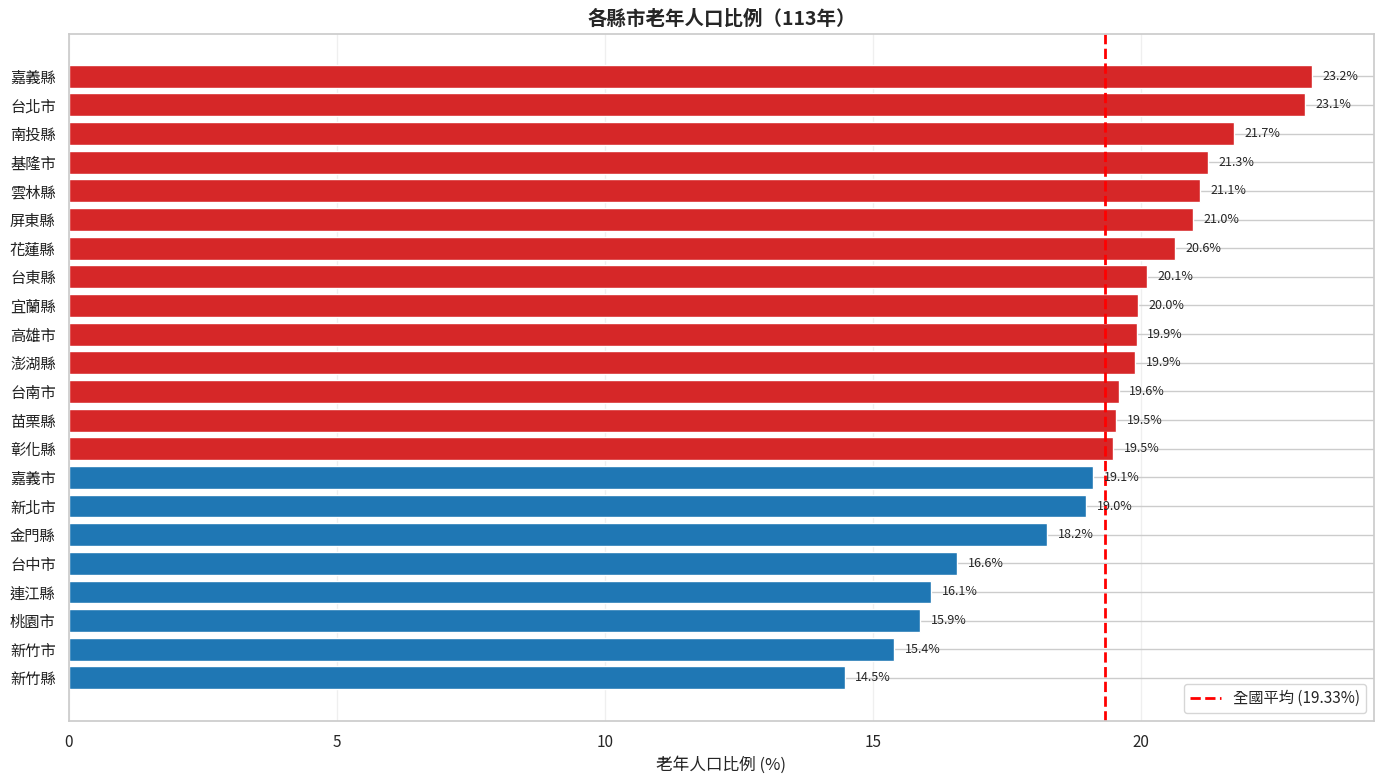

In [15]:
# 5.1 長條圖：各縣市老年人口比例
fig, ax = plt.subplots(figsize=(14, 8))

data = df.sort_values('老年人口比例(%)', ascending=True)
colors = ['#d62728' if x > avg_aging else '#1f77b4' for x in data['老年人口比例(%)']]

bars = ax.barh(data['縣市名稱'], data['老年人口比例(%)'], color=colors)
ax.axvline(x=avg_aging, color='red', linestyle='--', linewidth=2, label=f'全國平均 ({avg_aging:.2f}%)')

ax.set_xlabel('老年人口比例 (%)', fontsize=12)
ax.set_title('各縣市老年人口比例（113年）', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, data['老年人口比例(%)']):
    ax.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()


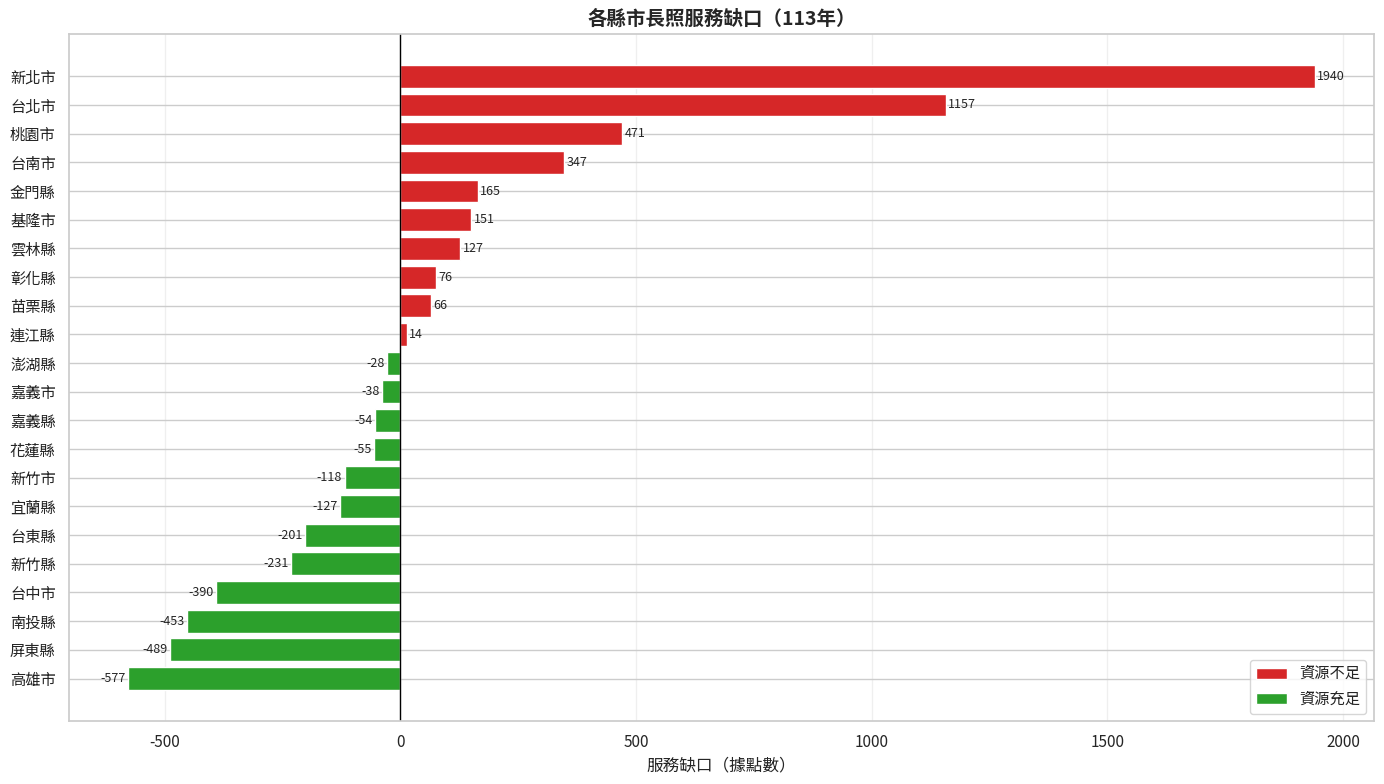

In [16]:
# 5.2 長條圖：各縣市服務缺口
fig, ax = plt.subplots(figsize=(14, 8))

data = df.sort_values('服務缺口', ascending=True)
colors = ['#d62728' if x > 0 else '#2ca02c' for x in data['服務缺口']]

bars = ax.barh(data['縣市名稱'], data['服務缺口'], color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

ax.set_xlabel('服務缺口（據點數）', fontsize=12)
ax.set_title('各縣市長照服務缺口（113年）', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, data['服務缺口']):
    offset = 5 if val >= 0 else -5
    ha = 'left' if val >= 0 else 'right'
    ax.text(val + offset, bar.get_y() + bar.get_height()/2, f'{val:.0f}', va='center', ha=ha, fontsize=9)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#d62728', label='資源不足'),
                   Patch(facecolor='#2ca02c', label='資源充足')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


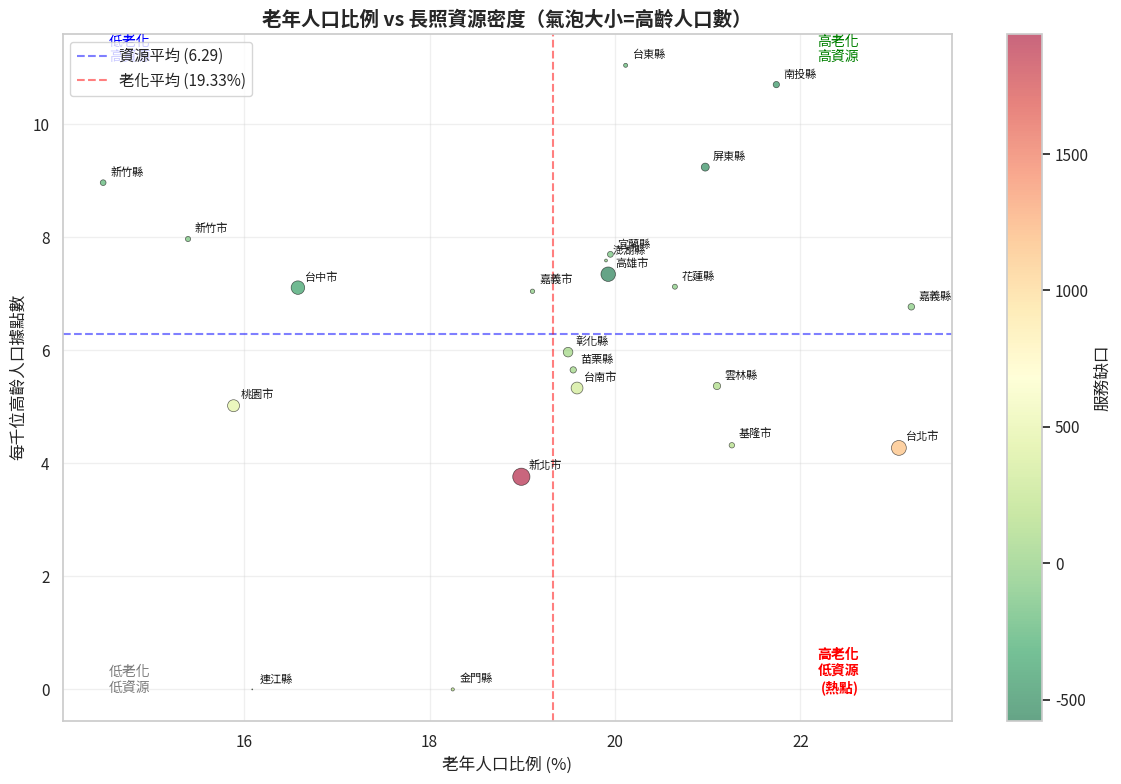

In [17]:
# 5.3 散佈圖：老年人口比例 vs 每千位高齡人口據點數
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['老年人口比例(%)'], df['每千位高齡人口據點數'], 
                     s=df['65歲以上']/5000, alpha=0.6, c=df['服務缺口'], 
                     cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)

# 添加縣市標籤
for idx, row in df.iterrows():
    ax.annotate(row['縣市名稱'], (row['老年人口比例(%)'], row['每千位高齡人口據點數']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 添加平均線
ax.axhline(y=avg_resource, color='blue', linestyle='--', alpha=0.5, label=f'資源平均 ({avg_resource:.2f})')
ax.axvline(x=avg_aging, color='red', linestyle='--', alpha=0.5, label=f'老化平均 ({avg_aging:.2f}%)')

# 標註四個象限
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[1]-1, ylim[1]-0.5, '高老化\n高資源', fontsize=10, ha='right', color='green')
ax.text(xlim[0]+0.5, ylim[1]-0.5, '低老化\n高資源', fontsize=10, ha='left', color='blue')
ax.text(xlim[1]-1, ylim[0]+0.5, '高老化\n低資源\n(熱點)', fontsize=10, ha='right', color='red', fontweight='bold')
ax.text(xlim[0]+0.5, ylim[0]+0.5, '低老化\n低資源', fontsize=10, ha='left', color='gray')

ax.set_xlabel('老年人口比例 (%)', fontsize=12)
ax.set_ylabel('每千位高齡人口據點數', fontsize=12)
ax.set_title('老年人口比例 vs 長照資源密度（氣泡大小=高齡人口數）', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter)
cbar.set_label('服務缺口')

plt.tight_layout()
plt.show()


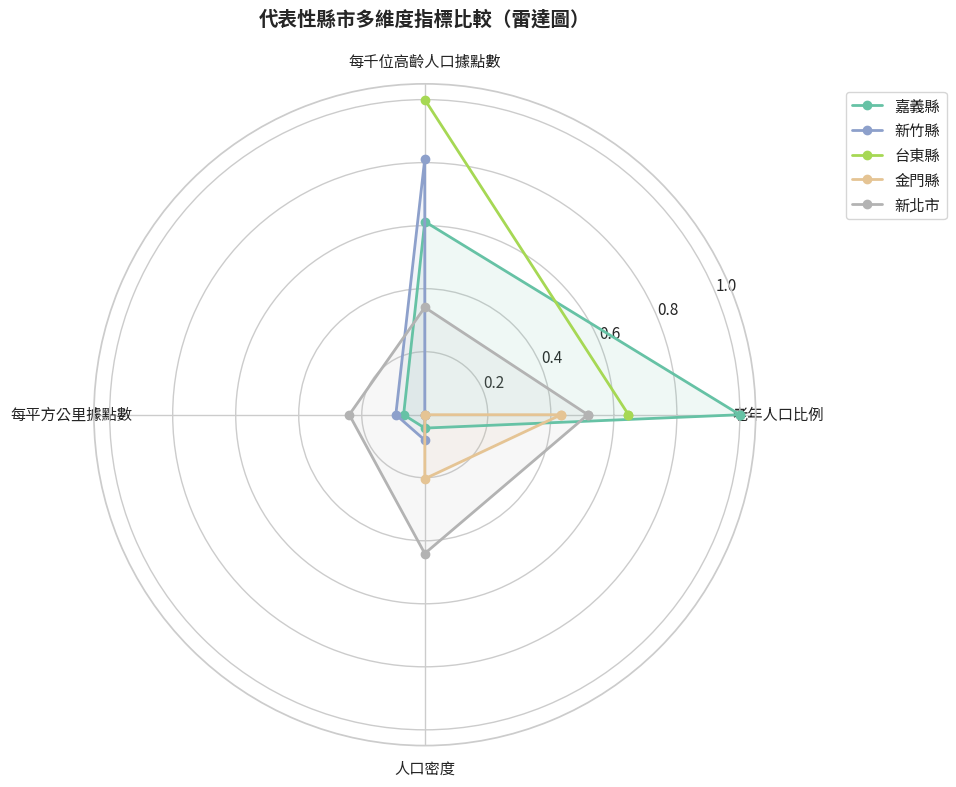

In [18]:
# 5.4 雷達圖：比較代表性縣市多維度指標
# 選取代表性縣市
selected_cities = [
    df.loc[df['老年人口比例(%)'].idxmax(), '縣市名稱'],  # 老化最高
    df.loc[df['老年人口比例(%)'].idxmin(), '縣市名稱'],  # 老化最低
    df.loc[df['每千位高齡人口據點數'].idxmax(), '縣市名稱'],  # 資源最多
    df.loc[df['每千位高齡人口據點數'].idxmin(), '縣市名稱'],  # 資源最少
    df.loc[df['總人口'].idxmax(), '縣市名稱'],  # 人口最多
]
selected_cities = list(dict.fromkeys(selected_cities))  # 去重保序

# 準備雷達圖資料
categories = ['老年人口比例', '每千位高齡人口據點數', '每平方公里據點數', '人口密度']
N = len(categories)

# 標準化各指標到 0-1 範圍
df_radar = df[df['縣市名稱'].isin(selected_cities)].copy()
for col, orig in zip(['老年人口比例(%)_norm', '每千位高齡人口據點數_norm', '每平方公里據點數_norm', '人口密度(人/km²)_norm'],
                     ['老年人口比例(%)', '每千位高齡人口據點數', '每平方公里據點數', '人口密度(人/km²)']):
    min_val = df[orig].min()
    max_val = df[orig].max()
    df_radar[col] = (df_radar[orig] - min_val) / (max_val - min_val)

# 繪製雷達圖
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

colors = plt.cm.Set2(np.linspace(0, 1, len(selected_cities)))

for idx, city in enumerate(selected_cities):
    city_data = df_radar[df_radar['縣市名稱'] == city]
    values = [
        city_data['老年人口比例(%)_norm'].values[0],
        city_data['每千位高齡人口據點數_norm'].values[0],
        city_data['每平方公里據點數_norm'].values[0],
        city_data['人口密度(人/km²)_norm'].values[0]
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=city, color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title('代表性縣市多維度指標比較（雷達圖）', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()


---

## 結論與建議


In [19]:
print("=" * 80)
print("研究結論與政策建議")
print("=" * 80)

print("\n【一、整體概況】")
print(f"分析年份: 113 年")
print(f"縣市數量: {len(df)} 個")
print(f"全國高齡人口: {df['65歲以上'].sum():,.0f} 人")
print(f"全國平均老年人口比例: {avg_aging:.2f}%")
print(f"全國長照據點總數: {df['總據點數'].sum():.0f} 個")
print(f"全國平均每千位高齡人口據點數: {avg_resource:.2f} 個")

print("\n【二、老化程度分析】")
top3_aging = df.nlargest(3, '老年人口比例(%)')[['縣市名稱', '老年人口比例(%)']]
print("老化程度最高前三名：")
for _, row in top3_aging.iterrows():
    print(f"  • {row['縣市名稱']}: {row['老年人口比例(%)']:.2f}%")

print("\n【三、資源不足熱點】")
if len(hotspots) > 0:
    print(f"共 {len(hotspots)} 個區域需優先關注：")
    for _, row in hotspots.iterrows():
        print(f"  • {row['縣市名稱']}: 老化率 {row['老年人口比例(%)']:.2f}%, 缺口 {row['服務缺口']:.0f} 個據點")
else:
    print("無明顯熱點區域")

print("\n【四、政策建議】")
priority_top5 = df.nlargest(5, '優先設置分數')[['縣市名稱', '服務缺口']]
print("建議優先設置長照據點的區域：")
for i, (_, row) in enumerate(priority_top5.iterrows(), 1):
    gap = max(0, row['服務缺口'])
    print(f"  {i}. {row['縣市名稱']}（建議增設 {gap:.0f} 個據點）")

print("\n" + "=" * 80)


研究結論與政策建議

【一、整體概況】
分析年份: 113 年
縣市數量: 22 個
全國高齡人口: 4,488,707 人
全國平均老年人口比例: 19.33%
全國長照據點總數: 26469 個
全國平均每千位高齡人口據點數: 6.29 個

【二、老化程度分析】
老化程度最高前三名：
  • 嘉義縣: 23.20%
  • 台北市: 23.06%
  • 南投縣: 21.74%

【三、資源不足熱點】
共 6 個區域需優先關注：
  • 台北市: 老化率 23.06%, 缺口 1157 個據點
  • 基隆市: 老化率 21.26%, 缺口 151 個據點
  • 雲林縣: 老化率 21.10%, 缺口 127 個據點
  • 台南市: 老化率 19.59%, 缺口 347 個據點
  • 苗栗縣: 老化率 19.55%, 缺口 66 個據點
  • 彰化縣: 老化率 19.49%, 缺口 76 個據點

【四、政策建議】
建議優先設置長照據點的區域：
  1. 台北市（建議增設 1157 個據點）
  2. 金門縣（建議增設 165 個據點）
  3. 基隆市（建議增設 151 個據點）
  4. 嘉義縣（建議增設 0 個據點）
  5. 雲林縣（建議增設 127 個據點）

